# ResNet PosInv-SupCon

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import random
import datetime
import os
import copy
import random
import shutil
import time
from tqdm import tqdm
import torchvision
import torchvision.transforms as transforms
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.backends.cudnn as cudnn
from functools import wraps
from dataclasses import dataclass
import math

In [2]:
!nvidia-smi

Wed Aug 13 14:40:58 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA L4                      Off |   00000000:00:03.0 Off |                    0 |
| N/A   34C    P8             11W /   72W |       0MiB /  23034MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## Dataset Download

In [ ]:
BASE_PATH = "/content/cub-200-2011/"

In [ ]:
!wget https://s3.amazonaws.com/fast-ai-imageclas/CUB_200_2011.tgz

sending incremental file list
CUB_200_2011.tgz
          1.15G 100%   52.32MB/s    0:00:20 (xfr#1, to-chk=0/1)


In [7]:
!tar -xf /content/CUB_200_2011.tgz -C /content/

## Difine seed

In [8]:
def set_seed(seed=200):
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    # optional
    # for numpy.random
    np.random.seed(seed)
    # for built-in random
    random.seed(seed)
    # for hash seed
    os.environ["PYTHONHASHSEED"] = str(seed)

## Define Model(ResNet)


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision.models as models


class Feature(nn.Module):
    def __init__(self, model='resnet18'):
        nn.Module.__init__(self)
        self.model = model

        self.base = models.__dict__[model](weights='IMAGENET1K_V1')

    def forward(self, x):
        x = self.base.conv1(x)
        x = self.base.bn1(x)
        x = self.base.relu(x)
        x = self.base.maxpool(x)

        x = self.base.layer1(x)
        x = self.base.layer2(x)
        x = self.base.layer3(x)
        x = self.base.layer4(x)

        x = self.base.avgpool(x)
        x = torch.flatten(x, 1)

        return x

def resnet18_pretrain(**kwargs):
    return Feature('resnet18')

def resnet34_pretrain(**kwargs):
    return Feature('resnet34')

def resnet50_pretrain(**kwargs):
    return Feature('resnet50')

model_dict = {
    'resnet18_pretrain': [resnet18_pretrain, 512],
    'resnet34_pretrain': [resnet34_pretrain, 512],
    'resnet50_pretrain': [resnet50_pretrain, 2048],
}



class LinearBatchNorm(nn.Module):
    """Implements BatchNorm1d by BatchNorm2d, for SyncBN purpose"""
    def __init__(self, dim, affine=True):
        super(LinearBatchNorm, self).__init__()
        self.dim = dim
        self.bn = nn.BatchNorm2d(dim, affine=affine)

    def forward(self, x):
        x = x.view(-1, self.dim, 1, 1)
        x = self.bn(x)
        x = x.view(-1, self.dim)
        return x


class SupConResNet(nn.Module):
    """backbone + projection head"""
    def __init__(self, name='resnet50', head='mlp', feat_dim=128):
        super(SupConResNet, self).__init__()
        model_fun, dim_in = model_dict[name]
        self.encoder = model_fun()
        if head == 'linear':
            self.head = nn.Linear(dim_in, feat_dim)
        elif head == 'mlp':
            self.head = nn.Sequential(
                nn.Linear(dim_in, dim_in),
                nn.ReLU(inplace=True),
                nn.Linear(dim_in, feat_dim)
            )
        else:
            raise NotImplementedError(
                'head not supported: {}'.format(head))

    def forward(self, x):
        feat = self.encoder(x)
        feat = F.normalize(self.head(feat), dim=1)
        return feat


class SupCEResNet(nn.Module):
    """encoder + classifier"""
    def __init__(self, name='resnet50', num_classes=10):
        super(SupCEResNet, self).__init__()
        model_fun, dim_in = model_dict[name]
        self.encoder = model_fun()
        self.fc = nn.Linear(dim_in, num_classes)

    def forward(self, x):
        return self.fc(self.encoder(x))


class LinearClassifier(nn.Module):
    """Linear classifier"""
    def __init__(self, name='resnet50', num_classes=10):
        super(LinearClassifier, self).__init__()
        _, feat_dim = model_dict[name]
        self.fc = nn.Linear(feat_dim, num_classes)

    def forward(self, features):
        return self.fc(features)

class SupConResNetWithEmbedding(nn.Module):
    """backbone + projection head"""
    def __init__(self, name='resnet50', head='mlp', feat_dim=128, num_classes=100):
        super(SupConResNetWithEmbedding, self).__init__()
        model_fun, dim_in = model_dict[name]
        self.encoder = model_fun()
        if head == 'linear':
            self.head = nn.Linear(dim_in, feat_dim)
        elif head == 'mlp':
            self.head = nn.Sequential(
                nn.Linear(dim_in, dim_in),
                nn.ReLU(inplace=True),
                nn.Linear(dim_in, feat_dim)
            )
        else:
            raise NotImplementedError(
                'head not supported: {}'.format(head))

        self.num_classes = num_classes
        self.embedding = nn.Embedding(self.num_classes, feat_dim, max_norm=True)

        label_range = torch.arange(0, num_classes, dtype=torch.int64).contiguous().view(-1, 1)
        emb_range = torch.arange(0, feat_dim, dtype=torch.int64).contiguous().view(-1, 1)
        init_emb_value = torch.eq(label_range, emb_range.T).float().cuda()

        self.embedding.weight.data.copy_(init_emb_value)

    def forward(self, x, emb_idx):
        feat = self.encoder(x)
        feat = F.normalize(self.head(feat), dim=1)
        return feat, F.normalize(self.embedding(emb_idx), dim=1)


## Define Loss

In [10]:
class PosInvSupConLoss(nn.Module):
    """Supervised Contrastive Learning: https://arxiv.org/pdf/2004.11362.pdf.
    It also supports the unsupervised contrastive loss in SimCLR"""
    def __init__(self, temperature=0.07, contrast_mode='all',
                 base_temperature=0.07):
        super(PosInvSupConLoss, self).__init__()
        self.temperature = temperature
        self.contrast_mode = contrast_mode
        self.base_temperature = base_temperature

    def forward(self, features, labels=None, mask=None):
        """Compute loss for model. If both `labels` and `mask` are None,
        it degenerates to SimCLR unsupervised loss:
        https://arxiv.org/pdf/2002.05709.pdf
        Args:
            features: hidden vector of shape [bsz, n_views, ...].
            labels: ground truth of shape [bsz].
            mask: contrastive mask of shape [bsz, bsz], mask_{i,j}=1 if sample j
                has the same class as sample i. Can be asymmetric.
        Returns:
            A loss scalar.
        """
        device = (torch.device('cuda')
                  if features.is_cuda
                  else torch.device('cpu'))

        if len(features.shape) < 3:
            raise ValueError('`features` needs to be [bsz, n_views, ...],'
                             'at least 3 dimensions are required')
        if len(features.shape) > 3:
            features = features.view(features.shape[0], features.shape[1], -1)

        batch_size = features.shape[0]
        if labels is not None and mask is not None:
            raise ValueError('Cannot define both `labels` and `mask`')
        elif labels is None and mask is None:
            mask = torch.eye(batch_size, dtype=torch.float32).to(device)
        elif labels is not None:
            labels = labels.contiguous().view(-1, 1)
            if labels.shape[0] != batch_size:
                raise ValueError('Num of labels does not match num of features')
            mask = torch.eq(labels, labels.T).float().to(device)
            other_mask = (~torch.eq(labels, labels.T)).float().to(device)
        else:
            mask = mask.float().to(device)

        contrast_count = features.shape[1]
        contrast_feature = torch.cat(torch.unbind(features, dim=1), dim=0)
        if self.contrast_mode == 'one':
            anchor_feature = features[:, 0]
            anchor_count = 1
        elif self.contrast_mode == 'all':
            anchor_feature = contrast_feature
            anchor_count = contrast_count
        else:
            raise ValueError('Unknown mode: {}'.format(self.contrast_mode))

        # compute logits
        anchor_dot_contrast = torch.div(
            torch.matmul(anchor_feature, contrast_feature.T),
            self.temperature)

        # for numerical stability
        logits_max, _ = torch.max(anchor_dot_contrast, dim=1, keepdim=True)
        logits = anchor_dot_contrast - logits_max.detach()

        # tile mask
        mask = mask.repeat(anchor_count, contrast_count)
        other_mask = other_mask.repeat(anchor_count, contrast_count)
        # mask-out self-contrast cases
        logits_mask = torch.scatter(
            torch.ones_like(mask),
            1,
            torch.arange(batch_size * anchor_count).view(-1, 1).to(device),
            0
        )

        # compute log_prob
        exp_logits = torch.exp(logits) * other_mask

        next_logits = exp_logits.sum(1, keepdim=True)
        next_logits = next_logits.repeat(1, logits.shape[0])
        next_logits = next_logits + torch.exp(logits)
        # print(other_mask)
        # print(mask)
        log_prob = logits - torch.log(next_logits)


        n = mask.sum(1)
        # print(torch.count_nonzero(n))
        sum_mask = torch.where(n==0, torch.ones_like(n), n)
        # print(sum_mask)
        # compute mean of log-likelihood over positive
        mean_log_prob_pos = (mask * log_prob).sum(1) / sum_mask
        # print(mean_log_prob_pos)
        # loss
        loss = - (self.temperature / self.base_temperature) * mean_log_prob_pos
        loss = loss.view(anchor_count, batch_size).sum() / torch.count_nonzero(n)

        return loss

## Define Utils

In [11]:
@dataclass
class Option():
    dataset: str = 'cub-200-2011'
    model: str = 'resnet18_pretrain'
    batch_size: int = 128
    num_workers: int = 2
    epochs: int = 200
    learning_rate: float = 0.2
    lr_decay_epochs: str = '100,150,175'
    lr_decay_rate: float = 0.1
    weight_decay: float = 1e-4
    momentum: float = 0.9
    cosine: bool = True
    warm: bool = True
    feat_dim: int = 256
    temp: float = 0.1
    trial: int = 4
    seed: int = 44
    n_cls: int = 200
opt = Option()
set_seed(opt.seed)

opt.model_path = f'seed{opt.seed}_{opt.model}_true_x448_ds_change_PosInv-SupCon_Embedding_init_0_epoch_feat_dim{opt.feat_dim}_equal_{opt.epochs}_batch_size_{opt.batch_size}_trial_{opt.trial}'
opt.tb_dir = f'{BASE_PATH}/tensorboards/{opt.dataset}'
if not os.path.isdir(opt.tb_dir):
    os.makedirs(opt.tb_dir)

opt.checkpoint_dir = f'{BASE_PATH}/checkpoints/{opt.dataset}'
if not os.path.isdir(opt.checkpoint_dir):
    os.makedirs(opt.checkpoint_dir)

iterations = opt.lr_decay_epochs.split(',')
opt.lr_decay_epochs = list([])
for it in iterations:
    opt.lr_decay_epochs.append(int(it))

if opt.cosine:
    opt.model_path = '{}_cosine'.format(opt.model_path)
# warm-up for large-batch training,
if opt.batch_size > 256:
    opt.warm = True
if opt.warm:
    opt.model_path = '{}_warm'.format(opt.model_path)
    opt.warmup_from = 0.01
    opt.warm_epochs = 10
    if opt.cosine:
        eta_min = opt.learning_rate * (opt.lr_decay_rate ** 3)
        opt.warmup_to = eta_min + (opt.learning_rate - eta_min) * (
                1 + math.cos(math.pi * opt.warm_epochs / opt.epochs)) / 2
    else:
        opt.warmup_to = opt.learning_rate

In [12]:
def adjust_learning_rate(args, optimizer, epoch):
    lr = args.learning_rate
    if args.cosine:
        eta_min = lr * (args.lr_decay_rate ** 3)
        lr = eta_min + (lr - eta_min) * (
                1 + math.cos(math.pi * epoch / args.epochs)) / 2
    else:
        steps = np.sum(epoch > np.asarray(args.lr_decay_epochs))
        if steps > 0:
            lr = lr * (args.lr_decay_rate ** steps)

    for param_group in optimizer.param_groups:
        param_group['lr'] = lr


def warmup_learning_rate(args, epoch, batch_id, total_batches, optimizer):
    if args.warm and epoch <= args.warm_epochs:
        p = (batch_id + (epoch - 1) * total_batches) / \
            (args.warm_epochs * total_batches)
        lr = args.warmup_from + p * (args.warmup_to - args.warmup_from)

        for param_group in optimizer.param_groups:
            param_group['lr'] = lr

In [13]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [14]:
def accuracy(output, target, topk=(1,)):
    """Computes the accuracy over the k top predictions for the specified values of k"""
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))
        res = []
        for k in topk:
            correct_k = correct[:k].contiguous().view(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size))
        return res

## DataLoader Define

In [15]:
from pathlib import Path
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

class CUBDataset(Dataset):
    def __init__(self, root, split="train", transform=None, use_bbox=True):
        self.root      = Path(root)
        self.transform = transform
        self.split     = split
        self.use_bbox  = use_bbox

        # --- ① ファイルをパース ------------------------------------------------
        self.img_paths = {}   # id -> relative path
        self.labels    = {}   # id -> 0-based label
        self.is_train  = {}   # id -> bool

        with open(self.root / "images.txt") as f:
            for line in f:
                img_id, rel = line.strip().split()
                self.img_paths[int(img_id)] = rel

        with open(self.root / "image_class_labels.txt") as f:
            for line in f:
                img_id, lbl = line.strip().split()
                self.labels[int(img_id)] = int(lbl) - 1  # 0-start

        with open(self.root / "train_test_split.txt") as f:
            for line in f:
                img_id, flag = line.strip().split()
                self.is_train[int(img_id)] = (flag == "1")

        # --- ② バウンディングボックス ------------------------------------------
        # bounding_boxes.txt: <id> <x> <y> <w> <h>
        self.bboxes = {}
        if self.use_bbox:
            with open(self.root / "bounding_boxes.txt") as f:
                for line in f:
                    img_id, x, y, w, h = map(float, line.strip().split())
                    self.bboxes[int(img_id)] = (x, y, x + w, y + h)

        # --- ③ split でフィルタ -------------------------------------------------
        self.ids = [
            i for i in self.img_paths
            if (self.is_train[i] if split == "train" else not self.is_train[i])
        ]

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, idx):
        img_id   = self.ids[idx]
        img_path = self.root / "images" / self.img_paths[img_id]
        label    = self.labels[img_id]

        img = Image.open(img_path).convert("RGB")

        # --- ④ BBox で Crop -----------------------------------------------------
        if self.use_bbox:
            x1, y1, x2, y2 = self.bboxes[img_id]
            img = img.crop((x1, y1, x2, y2))

        # --- ⑤ transform 適用 ----------------------------------------------------
        if self.transform:
            img = self.transform(img)

        return img, label



In [16]:
from torch.utils.data import DataLoader

transform_train = transforms.Compose([
    transforms.Resize(600, Image.BILINEAR),
    transforms.RandomCrop((448, 448)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

transform = transforms.Compose([
    transforms.Resize(600, Image.BILINEAR),
    transforms.CenterCrop((448, 448)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

train_ds = CUBDataset("/content/CUB_200_2011", split="train", transform=transform_train, use_bbox=False)
test_ds  = CUBDataset("/content/CUB_200_2011", split="test" , transform=transform, use_bbox=False)

train_loader = DataLoader(train_ds, batch_size=opt.batch_size, shuffle=True, num_workers=opt.num_workers)
test_loader = DataLoader(
    test_ds, batch_size=opt.batch_size, shuffle=False, num_workers=1)


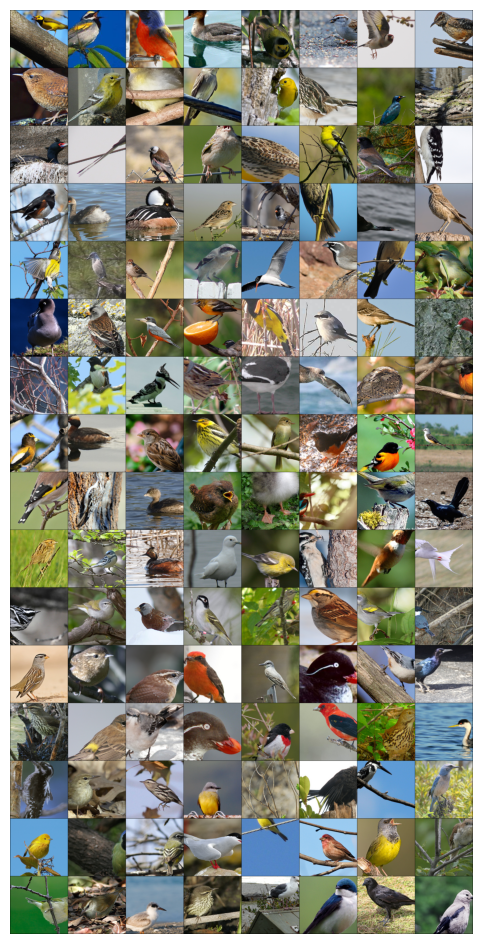

tensor([166, 165,  15,  89, 166, 115,  47, 193, 198, 174, 177, 101, 176, 109,
        133,  10,  23,  40,  33, 120,  87,  46,  75, 191,  20,  49,  88, 120,
        121,  26,  24, 149, 168,  73, 115, 110, 144, 113, 102, 154,   2,  33,
         81,  94,  97, 111,  90, 190,  75,  20,  80, 125,  64,  44, 104,  94,
         54,  50, 118, 162,  38,  20,  94,  40,  47,  27,  51, 198, 140,  82,
        147,  48, 123, 163,  49,  62, 174, 191,  68, 140, 158, 178,  33, 150,
        170, 132, 165,  81, 131, 198, 194,  41,  77,   6,  93,  48, 182, 170,
         90,   6,  56, 138, 148,  52, 186, 177, 158,  76, 127,   3,  80,  73,
        181,  74, 151, 140,  76,  34, 169,  30, 178, 177, 146, 182,  58, 137,
         28,  92])


In [17]:
import matplotlib.pyplot as plt
import torchvision
import numpy as np

def show_batch(images, mean=None, std=None, nrow=8):
    """
    images : Tensor [B, C, H, W]
    mean, std : 正規化を戻すときに使うリスト or タプル (チャンネル数分)
    """
    # ① 正規化を戻す（必要なら）
    if mean is not None and std is not None:
        images = images.clone()
        for c in range(images.size(1)):
            images[:, c] = images[:, c] * std[c] + mean[c]

    # ② Grid に並べる
    grid = torchvision.utils.make_grid(images, nrow=nrow, padding=2)
    npimg = grid.numpy().transpose((1, 2, 0))  # CHW → HWC

    # ③ 描画
    plt.figure(figsize=(12, 12))
    plt.imshow(np.clip(npimg, 0, 1))  # 0-1 範囲に収める
    plt.axis("off")
    plt.show()

# ─── 使い方 ───
images, labels = next(iter(train_loader))
show_batch(
    images,
    mean=[0.485, 0.456, 0.406],   # データに合わせて
    std=[0.229, 0.224, 0.225],
)
print(labels)

In [18]:
from torch.utils.tensorboard import SummaryWriter

current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tb_log_dir = f'{opt.tb_dir}/{opt.model_path}/{current_time}'

writer = SummaryWriter(log_dir=tb_log_dir, flush_secs=2)

# training

In [19]:

model = SupConResNetWithEmbedding(name=opt.model, feat_dim=opt.feat_dim, num_classes=opt.n_cls)
model.cuda()

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 203MB/s]


SupConResNetWithEmbedding(
  (encoder): Feature(
    (base): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (

In [20]:
def train(model, trainloader, optimizer, criterion, opt, epoch, writer, num_classes):
    model.train()
    losses = AverageMeter()
    adjust_learning_rate(opt, optimizer, epoch)
    for idx, (images, labels) in enumerate(trainloader):
      if torch.cuda.is_available():
          images = images.cuda(non_blocking=True)
          labels = labels.cuda(non_blocking=True)

      bsz = labels.shape[0]
      warmup_learning_rate(opt, epoch, idx, len(trainloader), optimizer)
      emb_idx = torch.arange(0, num_classes, dtype=torch.int64).cuda()
      features, emb_feature = model(images, emb_idx)
      features2 = torch.cat([features.unsqueeze(1), emb_feature.unsqueeze(1)], dim=0)
      labels2 = torch.cat([labels, emb_idx], dim=0)
      loss = criterion(features2, labels=labels2)

      # SGD
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # measure accuracy and record loss
      losses.update(loss.item(), bsz)

    writer.add_scalar('train/loss', losses.avg, epoch)
    return loss


In [ ]:
train_loss_results = []
train_contrastive_loss_results = []
best_loss = 80

criterion = PosInvSupConLoss(temperature=opt.temp).cuda()

optimizer = torch.optim.SGD(model.parameters(), lr=opt.learning_rate,
                      momentum=opt.momentum, weight_decay=opt.weight_decay)

for epoch in tqdm(range(1, opt.epochs + 1)):

  loss = train(model, train_loader, optimizer, criterion, opt, epoch, writer, opt.n_cls)

  state = {'epoch': epoch,
           'model': opt.model,
           'state_dict': model.state_dict(),
           'best_loss': best_loss,
           'optimizer' : optimizer.state_dict(),}

  torch.save(state, f"{opt.checkpoint_dir}/{opt.model_path}_last.pth.tar")
  if best_loss > loss:
    best_loss = loss
    print(best_loss)
    shutil.copyfile(f"{opt.checkpoint_dir}/{opt.model_path}_last.pth.tar", f"{opt.checkpoint_dir}/{opt.model_path}_best.pth.tar")



  0%|          | 0/200 [00:00<?, ?it/s]

tensor(2.4028, device='cuda:0', grad_fn=<DivBackward0>)


  0%|          | 1/200 [00:43<2:24:17, 43.51s/it]

tensor(1.7042, device='cuda:0', grad_fn=<DivBackward0>)


  1%|          | 2/200 [01:25<2:20:58, 42.72s/it]

tensor(1.3890, device='cuda:0', grad_fn=<DivBackward0>)


  2%|▏         | 3/200 [02:08<2:20:15, 42.72s/it]

tensor(1.1815, device='cuda:0', grad_fn=<DivBackward0>)


  2%|▏         | 4/200 [02:51<2:19:34, 42.73s/it]

tensor(1.0732, device='cuda:0', grad_fn=<DivBackward0>)


  4%|▍         | 8/200 [05:41<2:16:00, 42.50s/it]

tensor(1.0655, device='cuda:0', grad_fn=<DivBackward0>)


  4%|▍         | 9/200 [06:23<2:15:45, 42.65s/it]

tensor(1.0554, device='cuda:0', grad_fn=<DivBackward0>)


  5%|▌         | 10/200 [07:06<2:15:16, 42.72s/it]

tensor(1.0121, device='cuda:0', grad_fn=<DivBackward0>)


  6%|▌         | 11/200 [07:49<2:14:36, 42.73s/it]

tensor(0.9287, device='cuda:0', grad_fn=<DivBackward0>)


  6%|▌         | 12/200 [08:32<2:14:00, 42.77s/it]

tensor(0.8700, device='cuda:0', grad_fn=<DivBackward0>)


  6%|▋         | 13/200 [09:15<2:13:25, 42.81s/it]

tensor(0.7254, device='cuda:0', grad_fn=<DivBackward0>)


  7%|▋         | 14/200 [09:58<2:12:44, 42.82s/it]

tensor(0.7032, device='cuda:0', grad_fn=<DivBackward0>)


  8%|▊         | 16/200 [11:23<2:10:51, 42.67s/it]

tensor(0.6676, device='cuda:0', grad_fn=<DivBackward0>)


  8%|▊         | 17/200 [12:06<2:10:13, 42.69s/it]

tensor(0.6393, device='cuda:0', grad_fn=<DivBackward0>)


  9%|▉         | 18/200 [12:48<2:09:38, 42.74s/it]

tensor(0.5856, device='cuda:0', grad_fn=<DivBackward0>)


 10%|█         | 20/200 [14:14<2:08:09, 42.72s/it]

tensor(0.4871, device='cuda:0', grad_fn=<DivBackward0>)


 10%|█         | 21/200 [14:57<2:07:31, 42.75s/it]

tensor(0.4493, device='cuda:0', grad_fn=<DivBackward0>)


 11%|█         | 22/200 [15:40<2:06:58, 42.80s/it]

tensor(0.4000, device='cuda:0', grad_fn=<DivBackward0>)


 12%|█▏        | 23/200 [16:22<2:06:17, 42.81s/it]

tensor(0.3865, device='cuda:0', grad_fn=<DivBackward0>)


 13%|█▎        | 26/200 [18:30<2:03:42, 42.66s/it]

tensor(0.3854, device='cuda:0', grad_fn=<DivBackward0>)


 15%|█▌        | 30/200 [21:21<2:00:30, 42.53s/it]

tensor(0.3291, device='cuda:0', grad_fn=<DivBackward0>)


 16%|█▌        | 31/200 [22:03<2:00:00, 42.61s/it]

tensor(0.3286, device='cuda:0', grad_fn=<DivBackward0>)


 16%|█▋        | 33/200 [23:29<1:58:34, 42.60s/it]

tensor(0.2478, device='cuda:0', grad_fn=<DivBackward0>)


 20%|█▉        | 39/200 [27:44<1:54:04, 42.51s/it]

tensor(0.1917, device='cuda:0', grad_fn=<DivBackward0>)


 24%|██▎       | 47/200 [33:24<1:48:30, 42.55s/it]

tensor(0.1656, device='cuda:0', grad_fn=<DivBackward0>)


 26%|██▌       | 51/200 [36:15<1:45:43, 42.57s/it]

tensor(0.1395, device='cuda:0', grad_fn=<DivBackward0>)


 30%|██▉       | 59/200 [41:55<1:39:51, 42.50s/it]

tensor(0.1224, device='cuda:0', grad_fn=<DivBackward0>)


 30%|███       | 61/200 [43:21<1:38:34, 42.55s/it]

tensor(0.0797, device='cuda:0', grad_fn=<DivBackward0>)


 38%|███▊      | 75/200 [53:16<1:28:30, 42.49s/it]

tensor(0.0700, device='cuda:0', grad_fn=<DivBackward0>)


 38%|███▊      | 76/200 [53:59<1:28:05, 42.63s/it]

tensor(0.0563, device='cuda:0', grad_fn=<DivBackward0>)


 42%|████▏     | 83/200 [58:57<1:22:59, 42.56s/it]

tensor(0.0492, device='cuda:0', grad_fn=<DivBackward0>)


 44%|████▍     | 89/200 [1:03:12<1:18:41, 42.54s/it]

tensor(0.0443, device='cuda:0', grad_fn=<DivBackward0>)


 48%|████▊     | 96/200 [1:08:10<1:13:39, 42.49s/it]

tensor(0.0442, device='cuda:0', grad_fn=<DivBackward0>)


 48%|████▊     | 97/200 [1:08:53<1:13:07, 42.60s/it]

tensor(0.0403, device='cuda:0', grad_fn=<DivBackward0>)


 49%|████▉     | 98/200 [1:09:36<1:12:33, 42.68s/it]

tensor(0.0402, device='cuda:0', grad_fn=<DivBackward0>)


 53%|█████▎    | 106/200 [1:15:16<1:06:39, 42.55s/it]

tensor(0.0359, device='cuda:0', grad_fn=<DivBackward0>)


 56%|█████▌    | 112/200 [1:19:32<1:02:30, 42.62s/it]

tensor(0.0341, device='cuda:0', grad_fn=<DivBackward0>)


 60%|██████    | 121/200 [1:25:55<55:59, 42.53s/it]

tensor(0.0335, device='cuda:0', grad_fn=<DivBackward0>)


 61%|██████    | 122/200 [1:26:38<55:26, 42.64s/it]

tensor(0.0312, device='cuda:0', grad_fn=<DivBackward0>)


 62%|██████▏   | 123/200 [1:27:21<54:53, 42.77s/it]

tensor(0.0312, device='cuda:0', grad_fn=<DivBackward0>)


 62%|██████▎   | 125/200 [1:28:46<53:22, 42.70s/it]

tensor(0.0312, device='cuda:0', grad_fn=<DivBackward0>)


 64%|██████▍   | 128/200 [1:30:55<51:23, 42.82s/it]

tensor(0.0291, device='cuda:0', grad_fn=<DivBackward0>)


 71%|███████   | 142/200 [1:40:51<41:06, 42.53s/it]

tensor(0.0280, device='cuda:0', grad_fn=<DivBackward0>)


 74%|███████▎  | 147/200 [1:44:24<37:36, 42.58s/it]

tensor(0.0277, device='cuda:0', grad_fn=<DivBackward0>)


 83%|████████▎ | 166/200 [1:57:52<24:05, 42.52s/it]

tensor(0.0271, device='cuda:0', grad_fn=<DivBackward0>)


 90%|████████▉ | 179/200 [2:07:05<14:53, 42.54s/it]

tensor(0.0267, device='cuda:0', grad_fn=<DivBackward0>)


 90%|█████████ | 180/200 [2:07:48<14:12, 42.64s/it]

# SupConCEのコサイン類似度を見る

In [ ]:
class SimPrint(nn.Module):
    """Supervised Contrastive Learning: https://arxiv.org/pdf/2004.11362.pdf.
    It also supports the unsupervised contrastive loss in SimCLR"""
    def __init__(self, contrast_mode='all'):
        super(SimPrint, self).__init__()
        self.contrast_mode = contrast_mode

    def forward(self, features, features2, labels=None, mask=None):
        """Compute loss for model. If both `labels` and `mask` are None,
        it degenerates to SimCLR unsupervised loss:
        https://arxiv.org/pdf/2002.05709.pdf
        Args:
            features: hidden vector of shape [bsz, n_views, ...].
            labels: ground truth of shape [bsz].
            mask: contrastive mask of shape [bsz, bsz], mask_{i,j}=1 if sample j
                has the same class as sample i. Can be asymmetric.
        Returns:
            A loss scalar.
        """
        device = (torch.device('cuda')
                  if features.is_cuda
                  else torch.device('cpu'))

        batch_size = features.shape[0]

        labels = labels.contiguous().view(-1, 1)
        mask = torch.eq(labels, labels.T).float().to(device)
        neg_mask = (~torch.eq(labels, labels.T)).float().to(device)

        contrast_count = features.shape[1]

        anchor_count = contrast_count

        self_mask = F.one_hot(torch.arange(batch_size)).float().to(device)

        x = features
        y = features2
        anchor_dot_contrast = torch.matmul(x, y.T)
        # print(anchor_dot_contrast)
        other_mask = (mask - self_mask)

        negative_sim = (anchor_dot_contrast * neg_mask).sum(dim=-1) / neg_mask.sum(dim=-1)
        n = other_mask.sum(dim=-1)
        sum_mask = torch.where(n==0, torch.ones_like(n), n)
        positive_sim = (other_mask * anchor_dot_contrast).sum(dim=-1) / sum_mask
        self_loss = (self_mask * anchor_dot_contrast).sum(dim=-1)

        return positive_sim.mean(), negative_sim.mean(), self_loss.mean()

In [ ]:
train_loader = DataLoader(train_ds, batch_size=opt.batch_size, shuffle=True, num_workers=opt.num_workers)

In [ ]:
with torch.no_grad():
  pos_losses = AverageMeter()
  neg_losses = AverageMeter()
  self_losses = AverageMeter()
  for idx, (images, labels) in enumerate(train_loader):
      if torch.cuda.is_available():
          images = images.cuda(non_blocking=True)
          labels = labels.cuda(non_blocking=True)

      bsz = labels.shape[0]
      emb_idx = torch.arange(0, 200, dtype=torch.int64).cuda()
      features, _ = model(images, emb_idx)
      pos_loss, neg_loss, self_loss = SimPrint()(features, features, labels=labels)
      # contrastive_loss, pos_loss, neg_loss, self_loss = byol(images, images, labels, output=True)
      pos_losses.update(pos_loss.item(), bsz)
      neg_losses.update(neg_loss.item(), bsz)
      self_losses.update(self_loss.item(), bsz)
  print(pos_losses.val)
  print(neg_losses.val)
  print(self_losses.val)

In [ ]:
with torch.no_grad():
  pos_losses = AverageMeter()
  neg_losses = AverageMeter()
  self_losses = AverageMeter()
  # for idx, (images, labels) in enumerate(trainloader):
  if torch.cuda.is_available():
      images = images.cuda(non_blocking=True)
      labels = labels.cuda(non_blocking=True)

  bsz = labels.shape[0]
  emb_idx = torch.arange(0, 100, dtype=torch.int64).cuda()
  features, _emb = model(images, emb_idx)

  # pos_loss, neg_loss, self_loss = SimPrint()(features, features, labels=labels)
  # contrastive_loss, pos_loss, neg_loss, self_loss = byol(images, images, labels, output=True)
  # pos_losses.update(pos_loss.item(), bsz)
  # neg_losses.update(neg_loss.item(), bsz)
  # self_losses.update(self_loss.item(), bsz)
  print(pos_losses.val)
  print(neg_losses.val)
  print(self_losses.val)

## feature extraction

In [ ]:
train_loader = DataLoader(train_ds, batch_size=opt.batch_size, shuffle=True, num_workers=opt.num_workers)
test_loader = DataLoader(
    test_ds, batch_size=opt.batch_size, shuffle=False, num_workers=1)

In [ ]:
num_classes = 200
model = SupConResNetWithEmbedding(name=opt.model, feat_dim=opt.feat_dim, num_classes=num_classes)
model.cuda()
model.load_state_dict(torch.load(f"{opt.checkpoint_dir}/{opt.model_path}_last.pth.tar", map_location='cpu', weights_only=False)['state_dict'])

In [ ]:
opt = Option()
opt.learning_rate: float = 0.1
opt.epochs: int = 100
opt.lr_decay_epochs: str = '60,75,90'
opt.lr_decay_rate: float = 0.2
opt.weight_decay: float = 0
opt.momentum: float = 0.9
opt.best_model_path = f'seed{opt.seed}_{opt.model}_SupCon_Original_Last_classification_featdim_{opt.feat_dim}_epoch_{opt.epochs}_batch_size_{opt.batch_size}_best'
iterations = opt.lr_decay_epochs.split(',')
opt.lr_decay_epochs = list([])
for it in iterations:
    opt.lr_decay_epochs.append(int(it))

# warm-up for large-batch training,
if opt.batch_size > 256:
    opt.warm = True
if opt.warm:
    opt.best_model_path = '{}_warm'.format(opt.best_model_path)
    opt.warmup_from = 0.01
    opt.warm_epochs = 10
    if opt.cosine:
        eta_min = opt.learning_rate * (opt.lr_decay_rate ** 3)
        opt.warmup_to = eta_min + (opt.learning_rate - eta_min) * (
                1 + math.cos(math.pi * opt.warm_epochs / opt.epochs)) / 2
    else:
        opt.warmup_to = opt.learning_rate

In [ ]:
def linear_train(model, linear, trainloader, optimizer, criterion, opt, epoch, writer, num_classes):
    model.eval()
    linear.train()
    losses = AverageMeter()
    top1 = AverageMeter()
    top5 = AverageMeter()
    for idx, (images, labels) in enumerate(trainloader):
      if torch.cuda.is_available():
          images = images.cuda(non_blocking=True)
          labels = labels.cuda(non_blocking=True)

      bsz = labels.shape[0]
      warmup_learning_rate(opt, epoch, idx, len(trainloader), optimizer)
      with torch.no_grad():
          emb_idx = torch.arange(0, num_classes, dtype=torch.int64).cuda()
          feature = model.encoder(images)
      output = linear(feature.detach())
      loss = criterion(output, labels)

      # SGD
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # measure accuracy and record loss
      acc1, acc5 = accuracy(output, labels, topk=(1, 5))
      losses.update(loss.item(), bsz)
      top1.update(acc1[0], bsz)
      top5.update(acc5[0], bsz)

      # measure accuracy and record loss
      losses.update(loss.item(), bsz)


In [ ]:
def validation(model, linear, testloader, criterion, writer, epoch):
    model.eval()
    linear.eval()
    losses = AverageMeter()
    top1 = AverageMeter()
    top5 = AverageMeter()
    with torch.no_grad():
        for images, labels in testloader:
            if torch.cuda.is_available():
              images = images.cuda(non_blocking=True)
              labels = labels.cuda(non_blocking=True)
            bsz = labels.shape[0]

            feature = model.encoder(images)
            output = linear(feature.detach())
            loss = criterion(output, labels)
            # measure accuracy and record loss
            acc1, acc5 = accuracy(output, labels, topk=(1, 5))
            losses.update(loss.item(), bsz)
            top1.update(acc1[0], bsz)
            top5.update(acc5[0], bsz)

    return top1.avg, top5.avg

In [31]:
train_loss_results = []
best_loss = 80
best_online_net = None
best_accuracy = 0
best_model = None

criterion = nn.CrossEntropyLoss().cuda()
model.eval()

linear = LinearClassifier(name=opt.model, num_classes=200)
linear.cuda()
linear.train()
writer= None

optimizer = torch.optim.SGD(linear.parameters(), lr=opt.learning_rate,
                      momentum=opt.momentum, weight_decay=opt.weight_decay)

for epoch in tqdm(range(1, opt.epochs + 1)):
  adjust_learning_rate(opt, optimizer, epoch)
  linear_train(model, linear, train_loader, optimizer, criterion, opt, epoch, writer, num_classes)

  top1, top5 = validation(model, linear, test_loader, criterion, writer, epoch)
  if best_accuracy < top1:
    best_accuracy = top1
    print(best_accuracy)
  #   torch.save(classification.state_dict(), SAVE_CHECKPOINT_PATH + opt.best_model_path + ".model")
  #   best_model = classification


  1%|          | 1/100 [01:47<2:58:03, 107.92s/it]

tensor(27.0625, device='cuda:0')


  2%|▏         | 2/100 [03:35<2:56:02, 107.78s/it]

tensor(56.3859, device='cuda:0')


  3%|▎         | 3/100 [05:23<2:54:32, 107.96s/it]

tensor(67.0521, device='cuda:0')


  4%|▍         | 4/100 [07:11<2:52:45, 107.97s/it]

tensor(74.0076, device='cuda:0')


  5%|▌         | 5/100 [09:00<2:51:13, 108.14s/it]

tensor(77.1833, device='cuda:0')


  6%|▌         | 6/100 [10:47<2:49:10, 107.99s/it]

tensor(77.5975, device='cuda:0')


  7%|▋         | 7/100 [12:36<2:47:35, 108.13s/it]

tensor(78.0980, device='cuda:0')


 12%|█▏        | 12/100 [21:37<2:38:39, 108.18s/it]

tensor(78.2706, device='cuda:0')


 18%|█▊        | 18/100 [32:27<2:27:54, 108.22s/it]

tensor(78.3397, device='cuda:0')


 26%|██▌       | 26/100 [46:52<2:13:18, 108.09s/it]

tensor(78.5295, device='cuda:0')


 85%|████████▌ | 85/100 [2:33:34<27:20, 109.36s/it]

tensor(78.5468, device='cuda:0')


 87%|████████▋ | 87/100 [2:37:15<23:47, 109.77s/it]

tensor(78.5813, device='cuda:0')


100%|██████████| 100/100 [3:01:25<00:00, 108.86s/it]


In [32]:
best_accuracy

tensor(78.5813, device='cuda:0')